In [39]:
import mesa


def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [32]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

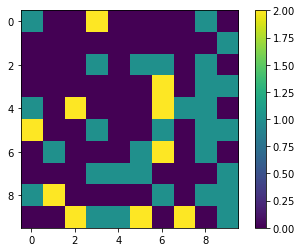

In [33]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

<AxesSubplot:>

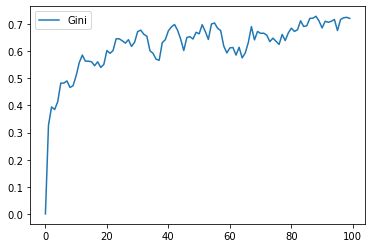

In [34]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [35]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

<AxesSubplot:>

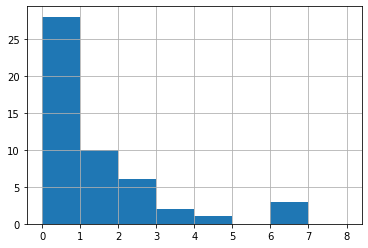

In [36]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1))

<AxesSubplot:xlabel='Step'>

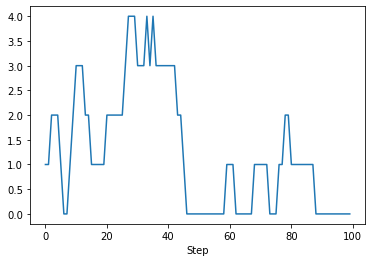

In [37]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [38]:
gini.to_csv("model_data.csv")
agent_wealth.to_csv("agent_data.csv")

In [40]:
params = {"width": 10, "height": 10, "N": range(10, 500, 10)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:33<00:00,  7.41it/s]


In [41]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')


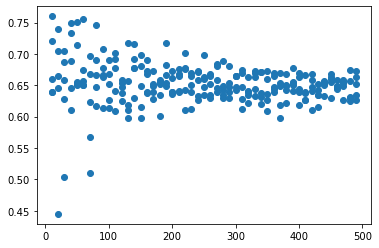

In [42]:
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
plt.scatter(N_values, gini_values)

In [43]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.N == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=25
    )
)
# For a prettier display we can also convert the data frame to html, uncomment to test in a Jupyter Notebook
from IPython.display import display, HTML
display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

 Step  AgentID  Wealth
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
    0        5       1
    0        6       1
    0        7       1
    0        8       1
    0        9       1
    1        0       1
    1        1       1
  ...      ...     ...
   99        8       0
   99        9       1
  100        0       0
  100        1       1
  100        2       4
  100        3       0
  100        4       2
  100        5       2
  100        6       1
  100        7       0
  100        8       0
  100        9       0


Step,AgentID,Wealth
0,0,1
0,1,1
0,2,1
0,3,1
0,4,1
0,5,1
0,6,1
0,7,1
0,8,1
0,9,1


In [44]:
results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step  Gini
    0  0.00
    1  0.00
    2  0.18
    3  0.18
    4  0.18
    5  0.18
    6  0.18
    7  0.18
    8  0.18
    9  0.18
   10  0.18
   11  0.18
  ...   ...
   89  0.66
   90  0.66
   91  0.66
   92  0.66
   93  0.66
   94  0.66
   95  0.66
   96  0.66
   97  0.66
   98  0.66
   99  0.66
  100  0.66
